In [1]:
from auditory_cortex.analyses import Correlations
from auditory_cortex.models import Regression
from auditory_cortex.neural_data.neural_meta_data import NeuralMetaData
from auditory_cortex.plotters.correlation_plotter import RegPlotter
from auditory_cortex.dataloader import DataLoader
import auditory_cortex.utils as utils

import os
import torch
import numpy as np


import scipy
# import jiwer
# import cupy as cp

import tensorflow.compat.v2 as tf

tf.enable_v2_behavior()

import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

import cupy as cp
import time

2024-05-30 21:25:42.911913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 21:25:44.628225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/gilbreth/cuda-toolkit/cuda-11.2.0/extras/CUPTI/lib64:/apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/intel64/lib:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/mic/lib:/apps/spack/gilbreth/apps/intel-parallel-studio/cl

In [58]:
from auditory_cortex import results_dir
results_dir

'/depot/jgmakin/data/auditory_cortex/results/'

#### regression using all trials..

In [3]:

session = 200206
bin_width=50
delay=50
num_folds=3
num_lmbdas=8
iterations=1
N_sents=500
return_dict=False
numpy=False
sents=None
test_sents=None
third=None
layer_IDs=None
poisson=False
lr=0.6
max_iterations=50
shuffled=False

In [2]:
model_name = 'whisper_tiny'
obj = Regression(model_name=model_name)

Creating regression obj for: 'whisper_tiny'
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


In [15]:
layer_IDs

In [5]:
obj.get_layer_IDs()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0


Model on device: cuda


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/preprocessor_config.json HTTP/1.1" 200 0


Loaded network from openai/whisper-tiny


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/whisper-tiny/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


[0, 1, 2, 3, 4, 5]

In [16]:
if poisson:
	numpy=True

if numpy:
	module = np
else:
	module = cp

if shuffled:
	print(f"Running regression for shuffled weights..")

if sents is None:
	sents = obj.dataloader.sent_IDs
if N_sents > len(sents):
	N_sents = len(sents)

if test_sents is None:
	test_sents = obj.dataloader.test_sent_IDs

# this creates a new dataset object and extracts the spikes
session = str(session)
# spikes = self.unroll_spikes(session, bin_width=bin_width, delay=delay)
num_channels = obj.dataloader.get_num_channels(session)
# _ = self.get_neural_spikes(session, bin_width=bin_width, delay=delay)
# num_channels = self.spike_datasets[session].num_channels
if layer_IDs is None:
	layer_IDs = obj.get_layer_IDs()

# loading features for any one sent=12, to get feature_dims..
feature_dims = obj.unroll_features(
	bin_width=bin_width, sents=[12], layer_IDs=layer_IDs, shuffled=shuffled
	).shape[-1]

# feature_dims = self.sampled_features[0].shape[1]
# lmbdas = module.logspace(start=-6, stop=-1, num=num_lmbdas)

lmbdas = module.logspace(start=-num_lmbdas//4, stop=num_lmbdas, num=int(1.25*num_lmbdas)+1)
# lmbdas = module.logspace(start=1, stop=8, num=7)
# lmbdas = module.logspace(start=5, stop=6, num=2)
B = module.zeros((len(layer_IDs), feature_dims, num_channels))
corr_coeff = np.zeros((iterations, num_channels, len(layer_IDs)))
poiss_entropy = np.zeros((iterations, num_channels, len(layer_IDs)))
poiss_entropy_baseline = np.zeros((iterations, num_channels, len(layer_IDs)))
uncertainty_per_spike = np.zeros((iterations, num_channels, len(layer_IDs)))
bits_per_spike_NLB = np.zeros((iterations, num_channels, len(layer_IDs)))
corr_coeff_train = np.zeros((iterations, num_channels, len(layer_IDs)))
# stimuli = np.array(list(self.raw_features[0].keys()))

stimuli = np.random.permutation(sents)[0:N_sents]
# mapping_sents = int(N_sents*0.7) # 70% test set...!
# size_of_chunk = int(mapping_sents/k)
print(f"# of iterations requested: {iterations}, \n \
		# of lambda samples per iteration: {len(lmbdas)}")
time_itr = 0
time_lmbda = 0
time_map = 0
# time_fold = 0
for n in range(iterations): 
	print(f"Itr: {n+1}:")
	start_itr = time.time()

	np.random.shuffle(stimuli)
	
	# if test_sents is None:
	#     mapping_set = stimuli[:mapping_sents]
	#     test_set = stimuli[mapping_sents:]
	# else:
	# option to fix the test set..!
	mapping_set = stimuli[np.isin(stimuli, test_sents, invert=True)]
	test_set = test_sents
	
	# lmbda_loss = module.zeros(((len(lmbdas), num_channels, self.num_layers)))
	start_lmbda = time.time()
	if poisson:
		lmbda_loss = obj.k_fold_CV_poisson_regression(
				session, bin_width=bin_width, delay=delay, mapping_set=mapping_set,
				lmbdas=lmbdas, num_folds=num_folds, layer_IDs=layer_IDs,
				lr = lr, max_iterations=max_iterations, shuffled=shuffled
			)
	else:
		lmbda_loss = obj.k_fold_CV(
				session, bin_width=bin_width, delay=delay, mapping_set=mapping_set,
				lmbdas=lmbdas, num_folds=num_folds, layer_IDs=layer_IDs,
				shuffled=shuffled
			)
	end_lmbda = time.time()
	time_lmbda += end_lmbda-start_lmbda
	optimal_lmbdas = lmbdas[np.argmin(lmbda_loss, axis=0)]
	start_map = time.time()
	# Loading Mapping set...!
	mapping_x = obj.unroll_features(
		bin_width=bin_width, sents=mapping_set, numpy=numpy, layer_IDs=layer_IDs,
		shuffled=shuffled
		)
	# mapping_x = module.stack([mapping_x[i] for i in range(self.num_layers)], axis=0)
	# mapping_y = self.unroll_spikes(session, sents=mapping_set, numpy=numpy)
	mapping_y = obj.unroll_spikes(session, bin_width=bin_width, delay=delay,
							sents=mapping_set, numpy=numpy)
	
	# mapping_y = self.get_neural_spikes(session, bin_width=bin_width, sents=mapping_set, numpy=numpy)
	#computing betas
	for l in range(len(layer_IDs)):
		for ch in range(num_channels):
			B[l,:,ch] = obj.regression(
				mapping_x[l,:,:], mapping_y[:,ch], optimal_lmbdas[ch,l],
				lr, max_iterations,
				poisson=poisson,
				)
			# B[l,:,ch] = utils.reg(mapping_x[l,:,:], mapping_y[:,ch], optimal_lmbdas[ch,l])
	# self.B[session] = cp.asnumpy(self.B[session])
	
	train_pred = utils.predict(mapping_x, B)
	corr_coeff_train[n] = utils.cc_norm(mapping_y, train_pred)

	del mapping_x
	del mapping_y
	# gc.collect()



Model on device: cuda
Loaded network from openai/whisper-tiny
Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_tiny/whisper_tiny_raw_features.pkl
Resamping ANN features at bin-width: 50
# of iterations requested: 1, 
 		# of lambda samples per iteration: 11
Itr: 1:
3_fold CV for session: 200206
For fold=0: 
For fold=1: 
For fold=2: 


In [7]:
layer_IDs

[0, 1, 2, 3, 4, 5]

In [17]:
# Loading test set...!
test_x = obj.unroll_features(
	bin_width=bin_width, sents=test_set, numpy=numpy, third=third,
	layer_IDs=layer_IDs, shuffled=shuffled
	)
test_y = obj.unroll_spikes(
	session, bin_width=bin_width, delay=delay, sents=test_set, numpy=numpy
	)

test_pred = utils.predict(test_x, B)

test_y_all_trials = obj.get_held_out_spikes(
		session, bin_width=bin_width, delay=delay, numpy=numpy)

Loading Neural data for session: 200206 ... Done.


In [10]:
bin_width

50

In [35]:
delay = 20
test_y = obj.unroll_spikes(
	session, bin_width=bin_width, delay=delay, sents=test_set, numpy=numpy
	)
test_y_all_trials = obj.get_held_out_spikes(
		session, bin_width=bin_width, delay=delay, numpy=numpy)

In [36]:
ch = 62
test_y[:10, ch]

array([ 0.,  0.,  0.,  4., 14.,  1., 11.,  0.,  4.,  1.], dtype=float32)

In [37]:
tr=0
test_y_all_trials[tr,:10, ch]

array([ 0.,  0.,  0., 11.,  7.,  8.,  4.,  0.,  5.,  0.])

In [18]:
session = 200213
sent=12
bin_width = 50
delay=50
sent_spikes = obj.dataloader.get_dataset_object(session=session).retrieve_spike_counts_for_all_trials(
	sent=sent, win = bin_width, delay=delay)
num_channels = len(sent_spikes)
sent_spikes = np.stack([sent_spikes[ch] for ch in range(num_channels)], axis=-1)

# individual trial loading...
rolled_spikes = obj.unroll_spikes(
	session, bin_width=bin_width, delay=delay, sents=[sent], numpy=True
	)

orig_spikes = obj.dataloader.get_dataset_object(session=session).extract_spikes(
	bin_width, delay, sents=[sent])

Reading neural spikes from dataset object. 


In [23]:
sents = [12, 13]

In [24]:
sents[0]

12

In [30]:

repeated_spikes = obj.dataloader.get_dataset_object(session=session).get_repeated_trials(
	sents=[12], bin_width=50, delay=0
)

In [31]:
repeated_spikes.shape

(11, 27, 64)

In [33]:
rand_dict = {}
for i in range(2):
	rand_dict[i] = np.random.randn(2,2)


In [38]:
rand_dict

{0: array([[ 0.6999162 , -0.31670195],
        [-1.2454524 , -0.36927643]]),
 1: array([[-2.26011967,  0.19928643],
        [ 0.13309733,  0.9619616 ]])}

In [45]:
next(iter(rand_dict.values())).shape[-1]

2

In [58]:
trial_ids = np.arange(11)
np.random.choice(trial_ids, size=2, replace=False)

array([10,  7])

In [19]:
ch = 10
orig_spikes[sent][:,ch]

array([1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 5, 2, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0], dtype=int32)

In [20]:
rolled_spikes[:,ch]

array([1., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 5., 2., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 0.], dtype=float32)

In [21]:
tr=0
sent_spikes[tr,:,ch]

array([1., 0., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 5., 2., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.])

In [60]:
from auditory_cortex import cache_dir
cache_dir

'/scratch/gilbreth/ahmedb/cache'

In [82]:
raw_spikes = obj.dataloader.get_session_spikes(
	session=session, bin_width=bin_width, delay=delay)

In [85]:
raw_spikes[sent][:,ch]

array([ 0,  0,  0,  4, 14,  1, 11,  0,  4,  1,  5, 10, 12, 11,  8,  2,  0,
        0, 15,  8,  7, 12,  3,  0,  2,  9,  1,  3], dtype=int32)

In [ ]:
ch = 32
test_y[:10, ch]

In [18]:
trial_corr = []
total_trial_repeats = 11
for tr in range(total_trial_repeats):
	trial_corr.append(utils.cc_norm(test_y_all_trials[tr], test_pred))

In [19]:
layer = 2
orig_corr = np.median(utils.cc_norm(test_y, test_pred)[:,layer])

avg_corr = np.median(np.mean(np.stack(trial_corr, axis=0), axis=0)[:,layer])

print(f"For session-{session}, {model_name}, L{layer}:")
print(f"Original: {orig_corr:.3f}, avg.: {avg_corr:.3f}")

print("---------------------------------")

for tr in range(11):
	print(f"For tr-{tr}, median corr: {np.median(trial_corr[tr][:,layer]):.3f}")

For session-200206, whisper_tiny, L2:
Original: 0.438, avg.: 0.168
---------------------------------
For tr-0, median corr: 0.143
For tr-1, median corr: 0.195
For tr-2, median corr: 0.171
For tr-3, median corr: 0.191
For tr-4, median corr: 0.146
For tr-5, median corr: 0.161
For tr-6, median corr: 0.165
For tr-7, median corr: 0.170
For tr-8, median corr: 0.154
For tr-9, median corr: 0.167
For tr-10, median corr: 0.162


In [12]:
layer = 2
orig_corr = np.median(utils.cc_norm(test_y, test_pred)[:,layer])


avg_corr = np.median(np.mean(np.stack(trial_corr, axis=0), axis=0)[:,layer])


print(f"For session-{session}, {model_name}, L{layer}:")
print(f"Original: {orig_corr:.3f}, avg.: {avg_corr:.3f}")

print("---------------------------------")

for tr in range(11):
	print(f"For tr-{tr}, median corr: {np.median(trial_corr[tr][:,layer]):.3f}")

For session-200206, whisper_tiny, L2:
Original: 0.438, avg.: 0.435
---------------------------------
For tr-0, median corr: 0.438
For tr-1, median corr: 0.475
For tr-2, median corr: 0.474
For tr-3, median corr: 0.453
For tr-4, median corr: 0.439
For tr-5, median corr: 0.430
For tr-6, median corr: 0.467
For tr-7, median corr: 0.457
For tr-8, median corr: 0.446
For tr-9, median corr: 0.473
For tr-10, median corr: 0.423


In [40]:
avg_corr.shape

(64,)

In [28]:
tr=0
np.median(utils.compute_avg_test_corr(test_y_all_trials, test_pred, tr)[:,layer])

0.1426462213485486

0.3411406329917459

In [24]:
test_y = test_y[None, ...]

In [25]:
test_y.shape

(1, 822, 64)

In [27]:
test_y_all_trials = self.get_held_out_spikes(
		self, session, bin_width=20, delay=0, numpy=False):

def compute_avg_test_corr(self, test_y_all_trials, test_pred):
	"""Computes correlation for each trial and averages across all trials."""

	trial_corr = []
	for tr in range(testest_y_all_trialst_y.shape[0]):
		trial_corr.append(utils.cc_norm(test_y_all_trials[tr], test_pred))
	trial_corr = np.stack(trial_corr, axis=0)
	trial_corr = np.mean(trial_corr, axis=0)
	return trial_corr

In [18]:
corr_cc = utils.cc_norm(test_y, test_pred)

In [19]:
corr_cc.shape

(64, 12)

In [23]:
repeated_trials = obj.dataloader.get_neural_data_for_repeated_trials(
	session, bin_width=20, delay=0)
    

In [22]:
type(repeated_trials)

numpy.ndarray

In [11]:
# Loading test set...!
test_x = obj.unroll_features(
	bin_width=bin_width, sents=test_set, numpy=numpy, third=third,
	layer_IDs=layer_IDs, shuffled=shuffled
	)
test_y = obj.unroll_spikes(
	session, bin_width=bin_width, delay=delay, sents=test_set, numpy=numpy
	)
# test_y = self.get_neural_spikes(session, bin_width=bin_width, sents=test_set, numpy=numpy, third=third) 

test_pred = utils.predict(test_x, B)

if poisson:
	corr_coeff[n] = utils.cc_norm(test_y, np.exp(test_pred))
else:
	corr_coeff[n] = utils.cc_norm(test_y, test_pred)


In [ ]:
poisson = False
corr_dict = obj.cross_validated_regression(
                session, bin_width=bin_width, delay=delay, iterations=iterations,
                num_folds=k_folds_validation, return_dict=True,
                numpy=use_cpu, layer_IDs=layer_IDs,
                poisson=poisson
            )

In [1]:
from auditory_cortex import opt_inputs_dir

opt_inputs_dir

'/depot/jgmakin/data/auditory_cortex/results/optimal_inputs'

In [2]:
from auditory_cortex.io_utils.io import read_model_parameters

beta_bank = read_model_parameters('strf_model')

In [13]:
dir_path = os.path.dirname('/scratch/gilbreth/ahmedb/data/voxpopuli/raw_audios/original_2009.tar')
os.path.join(dir_path, os.listdir(dir_path)[0])

'/scratch/gilbreth/ahmedb/data/voxpopuli/raw_audios/tmphi2o5_u6'

In [14]:
os.path.dirname('/scratch/gilbreth/ahmedb/data/voxpopuli/raw_audios/original_2009.tar')

'/scratch/gilbreth/ahmedb/data/voxpopuli/raw_audios'

In [15]:
dir_path.as_posix()

AttributeError: 'str' object has no attribute 'as_posix'

In [ ]:
os.listdir()

In [9]:
from torchaudio.datasets.utils import _extract_tar

In [7]:
from torch.hub import download_url_to_file 

In [2]:
tf.config.list_logical_devices('GPU')

2024-03-19 23:20:44.458842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 23:20:46.717099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12446 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:21:00.0, compute capability: 8.0


[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [2]:
# model_name = 'wav2letter_modified'
model_name = 'deepspeech2'
# obj = Regression(model_name=model_name)
dataloader = DataLoader()

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


In [3]:
session = 180413
spikes = dataloader.get_session_spikes(session=session, bin_width=40)

DataLoader: Extracting spikes for session-180413...Loading Neural data for session: 180413 ... Done.
Done.
Spikes for session: '180413' saved to file: /scratch/gilbreth/ahmedb/cache/neural/neural_spikes_session_wise_bw_40ms_delay_0ms.pkl


In [7]:
spikes[12].shape

(69, 16)

### trained vs untrained (ladder plot)...

In [4]:
area = 'all'
bin_width = 20
delay = 0
normalized = True
column = None
trained_identifier = 'bins_corrected_100'
untrained_identifier = 'reset_weights'

model_name = 'deepspeech2'

In [3]:
# trained_network...
# identifier='_bins_corrected_100'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
    bin_width=bin_width, poisson_normalizer=True
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized,
        column=column
    )

# weights shuffled ...
# identifier='_weights_shuffled'
corr_obj_shuffled = Correlations(model_name+'_'+untrained_identifier)
data_dist_shuffled = corr_obj_shuffled.get_corr_all_layers_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized,
        column=column
    )

NameError: name 'model_name' is not defined

Text(0.5, 1.0, 'L-0: shuffled (left) - trained (right)')

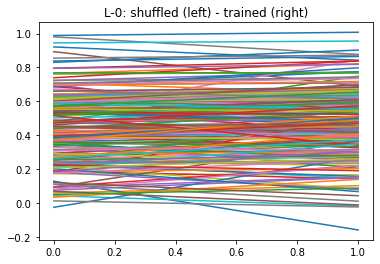

In [19]:
layer_ID = 0
d1 = data_dist_shuffled[layer_ID]
d2 = data_dist_trained[layer_ID]
for i in range(d1.size):
    plt.plot([0,1], [d1[i], d2[i]])
plt.title(f"L-{layer_ID}: shuffled (left) - trained (right)")


Text(0.5, 1.0, 'L-1: shuffled (left) - trained (right)')

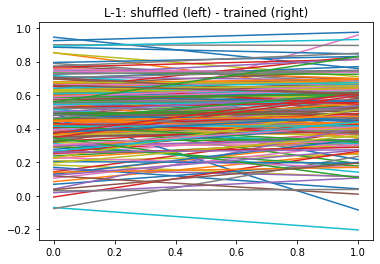

In [20]:
layer_ID = 1
d1 = data_dist_shuffled[layer_ID]
d2 = data_dist_trained[layer_ID]
for i in range(d1.size):
    plt.plot([0,1], [d1[i], d2[i]])
plt.title(f"L-{layer_ID}: shuffled (left) - trained (right)")


Text(0.5, 1.0, 'L-2: shuffled (left) - trained (right)')

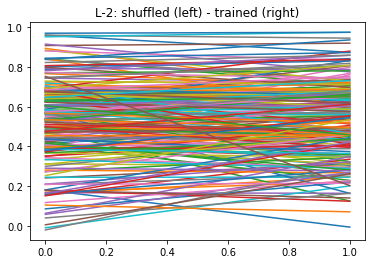

In [22]:
layer_ID = 2
d1 = data_dist_shuffled[layer_ID]
d2 = data_dist_trained[layer_ID]
for i in range(d1.size):
    plt.plot([0,1], [d1[i], d2[i]])
plt.title(f"L-{layer_ID}: shuffled (left) - trained (right)")

Text(0.5, 1.0, 'L-3: shuffled (left) - trained (right)')

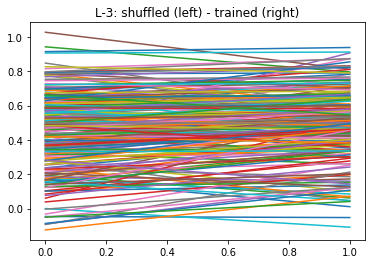

In [21]:
layer_ID = 3
d1 = data_dist_shuffled[layer_ID]
d2 = data_dist_trained[layer_ID]
for i in range(d1.size):
    plt.plot([0,1], [d1[i], d2[i]])
plt.title(f"L-{layer_ID}: shuffled (left) - trained (right)")


### saving the preedictions, comparing the Entropy and Correlations...

In [3]:
import time
session = 200206
bin_width = 20
delay = 0
iterations = 1
k_folds_validation = 3
use_cpu = False
layer_IDs = [2]
sents = None
num_lmbdas = 12
num_folds = 3

In [4]:
poisson = True
test_y, test_pred, B, optimal_lmbdas, lmbda_loss = obj.cross_validated_regression(
                session, bin_width=bin_width, delay=delay, iterations=1,
                num_folds=k_folds_validation, return_dict=False,
                numpy=use_cpu, layer_IDs=layer_IDs,
                poisson=poisson,
                max_iterations=50, lr=0.6, num_lmbdas=num_lmbdas
            )

Resamping ANN features at bin-width: 20
# of iterations requested: 1, 
                 # of lambda samples per iteration: 2
Itr: 1:
3_fold CV for session: 200206


2024-03-27 11:05:27.923196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 11:05:31.007455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14687 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-03-27 11:05:31.008303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14687 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


For fold=0: 


2024-03-27 11:05:32.842578: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5574cf048400


For fold=1: 
For fold=2: 
It takes (on avg.) 180.14 sec (all lmbdas). (time for 3-folds)
It takes (on avg.) 33.15 sec/mapping.
It takes (on avg.) 3.55 minutes/iteration...!


In [5]:
test_y.shape

(822, 64)

In [3]:
from auditory_cortex.io_utils.io import write_lmbdas, cache_glm_parameters, read_cached_glm_parameters
model_name = 'deepspeech2'
existing = read_cached_glm_parameters(model_name, 180627)

Reading from file: /scratch/gilbreth/ahmedb/cache/glm/deepspeech2/deepspeech2_sess_180627_glm_parameters_20ms.pkl


In [6]:
existing[2].keys()

dict_keys(['neural_spikes', 'glm_coefficients', 'natural_param'])

In [7]:
existing[2]['natural_param'].shape

(822, 16, 1)

In [6]:
test_pred.shape

(822, 64, 1)

In [8]:
combined = np.concatenate([test_pred, test_pred], axis=2)

In [9]:
combined.shape

(822, 64, 2)

In [11]:
combined = np.stack([test_y], axis=2)
combined.shape

(822, 64, 1)

In [12]:
corr_coeff = utils.cc_norm(test_y, np.exp(test_pred))

In [13]:
corr_coeff.shape

(64, 1)

In [14]:
poiss_entropy = utils.poisson_cross_entropy(test_y, test_pred)
poiss_entropy.shape

(64, 1)

In [16]:
poiss_entropy.transpose((1,0)).shape

(1, 64)

In [22]:
num_lmbdas = 8
lmbdas = np.logspace(start=-num_lmbdas//4, stop=num_lmbdas, num=int(1.25*num_lmbdas)+1)
lmbdas

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08])

In [5]:
corr_coeff.shape

(1, 64)

In [13]:
uncertainty_per_spike.transpose((1,0)).shape

(1, 64)

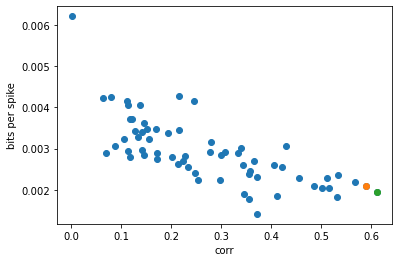

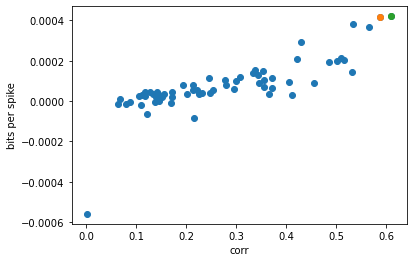

In [12]:
corr_coeff = corr_coeff.squeeze()
for metric in [uncertainty_per_spike, bits_per_spike_NLB]:
    fig, ax = plt.subplots()
    ax.scatter(corr_coeff, metric)
    ax.scatter(corr_coeff[32], metric[32])
    ax.scatter(corr_coeff[62], metric[62])
    ax.set_xlabel('corr')
    ax.set_ylabel('bits per spike')

In [6]:
B.shape

(1, 2048, 64)

In [8]:
test_set = obj.dataloader.test_sent_IDs

test_x = obj.unroll_features(
                bin_width=20, sents=test_set, numpy=True, third=None,
                layer_IDs=layer_IDs
                )
test_y = obj.unroll_spikes(
    session, bin_width=20, delay=0, sents=test_set, numpy=True
    )

In [9]:
test_x.shape

(1, 822, 2048)

In [10]:
test_pred = utils.predict(test_x, B)

In [ ]:
neural_spikes = {
    'actual': test_y,
    'predicted': test_pred
}

In [11]:
from auditory_cortex import results_dir
results_dir

'/depot/jgmakin/data/auditory_cortex/results/'

In [12]:
import pickle
neural_spikes_filename = f"sess-{session}_test_neural_activity.pkl"
file_path = os.path.join(results_dir, neural_spikes_filename)

neural_spikes = {
    'actual': test_y,
    'predicted': test_pred
}

with open(file_path, 'wb') as F: 
        pickle.dump(neural_spikes, F)

In [13]:
cross_entropy = utils.poisson_cross_entropy(test_y, test_pred)

In [21]:
file_path

'/depot/jgmakin/data/auditory_cortex/results/sess-200206_test_neural_activity.pkl'

(array([ 1.,  0.,  0.,  2.,  0.,  2.,  4., 10., 12., 33.]),
 array([-0.25755331, -0.13299359, -0.00843387,  0.11612585,  0.24068557,
         0.36524529,  0.48980501,  0.61436473,  0.73892445,  0.86348417,
         0.98804389]),
 <BarContainer object of 10 artists>)

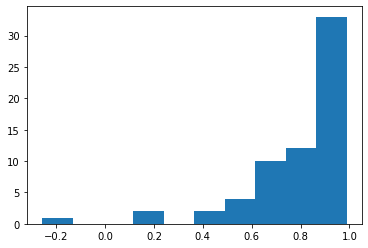

In [15]:
plt.hist(cross_entropy.squeeze())

In [28]:
poisson_loss = torch.nn.PoissonNLLLoss(log_input=True, full=True, reduction='none')

with torch.no_grad():
    ref_tensor = torch.tensor(test_y)
    predictions_tensor = torch.tensor(test_pred)
    ref_tensor = ref_tensor.transpose(0,1).unsqueeze(dim=1)
    predictions_tensor = predictions_tensor.transpose(0,1).transpose(1,2)

    loss = poisson_loss(predictions_tensor, ref_tensor)
    loss = torch.mean(loss, dim=2).cpu().numpy()

(array([ 1.,  8., 10., 14., 10.,  7.,  4.,  6.,  2.,  2.]),
 array([0.51190074, 0.70250619, 0.89311164, 1.08371709, 1.27432254,
        1.46492798, 1.65553343, 1.84613888, 2.03674433, 2.22734978,
        2.41795523]),
 <BarContainer object of 10 artists>)

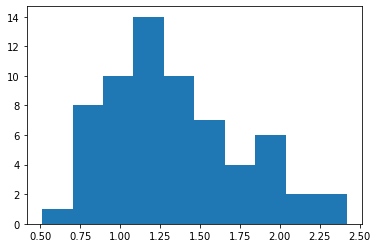

In [29]:
plt.hist(loss.squeeze())

In [30]:
corr = utils.cc_norm(test_y, np.exp(test_pred))

(array([ 1., 11., 12.,  8.,  7.,  9.,  5.,  3.,  5.,  3.]),
 array([0.00171583, 0.0626196 , 0.12352337, 0.18442715, 0.24533092,
        0.3062347 , 0.36713847, 0.42804225, 0.48894602, 0.54984979,
        0.61075357]),
 <BarContainer object of 10 artists>)

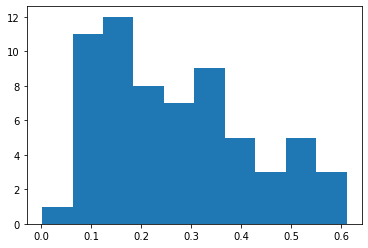

In [31]:
plt.hist(corr)

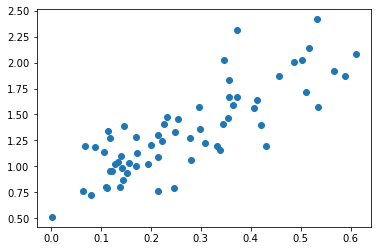

In [32]:
plt.scatter(corr.squeeze(), loss.squeeze())

#### Makins correction...

In [9]:
import sys
import os
import pdb

import numpy as np
import pickle
import matplotlib.pyplot as plt
from utils_jgm.machine_compatibility_utils import MachineCompatibilityUtils
from auditory_cortex import results_dir
# from utils_jgm.toolbox import r_pearson, Poisson_cross_entropy
MCUs = MachineCompatibilityUtils()

file_name = os.path.join(
    results_dir,
    'sess-200206_test_neural_activity.pkl'
    )
with open(file_name, 'rb') as f:
    spikes_and_predictions = pickle.load(f)
natural_params = spikes_and_predictions['predicted'][:,:,0]
data = spikes_and_predictions['actual']

# pre-compute number of samples and number of channels...
Nsamples, Nchannels = data.shape
data_sums = np.sum(data, axis=0, keepdims=True)
data_means = data_sums/Nsamples

# corr = r_pearson(data.T, np.exp(natural_params).T, MATRIX=False)
# xntrp = Poisson_cross_entropy(data.T, natural_params.T)
# xntrp_baseline = Poisson_cross_entropy(data.T, np.log(data_means.T)) #bits_per_spike metri

corr = utils.cc_norm(data, np.exp(natural_params))
xntrp = utils.poisson_cross_entropy(data, natural_params[...,None])
xntrp_baseline = utils.poisson_cross_entropy(data, np.log(data_means[...,None]))

uncertainty_per_spike = xntrp/data_sums.T/np.log(2)
bits_per_spike_NLB = (xntrp_baseline - xntrp)/data_sums.T/np.log(2)

In [36]:
data_means.shape

(1, 64)

In [24]:
from auditory_cortex import results_dir
results_dir

'/depot/jgmakin/data/auditory_cortex/results/'

In [11]:
corr.shape

(64,)

In [10]:
data.shape

(822, 64)

In [35]:
xntrp_baseline.shape

(64, 1)

In [34]:
uncertainty_per_spike.shape

(64, 1)

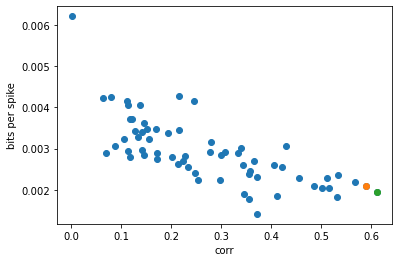

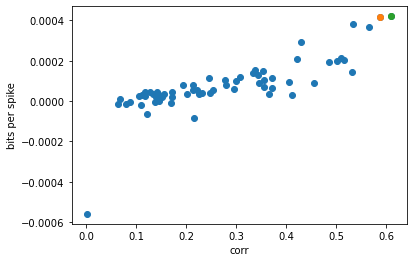

In [33]:
for metric in [uncertainty_per_spike, bits_per_spike_NLB]:
    fig, ax = plt.subplots()
    ax.scatter(corr, metric)
    ax.scatter(corr[32], metric[32])
    ax.scatter(corr[62], metric[62])
    ax.set_xlabel('corr')
    ax.set_ylabel('bits per spike')

In [30]:
xntrp.shape

(64, 1)

In [31]:
data_sums.shape

(1, 64)

In [28]:
data_means.shape

(1, 64)

In [23]:
corr.shape

(64,)

In [20]:
np.log(2)

0.6931471805599453

0.0

### GLIM..

In [4]:
import time
session = 200206
bin_width = 20
delay = 0
iterations = 1
k_folds_validation = 3
use_cpu = False
layer_IDs = [2]
sents = None
num_lmbdas = 12
num_folds = 3

In [5]:
poisson = False
corr_dict = obj.cross_validated_regression(
                session, bin_width=bin_width, delay=delay, iterations=iterations,
                num_folds=k_folds_validation, return_dict=True,
                numpy=use_cpu, layer_IDs=layer_IDs,
                poisson=poisson
            )

Resamping ANN features at bin-width: 20
# of iterations requested: 1, 
                 # of lambda samples per iteration: 11
Itr: 1:
3_fold CV for session: 200206
For fold=0: 
For fold=1: 
For fold=2: 


TypeError: Unsupported type <class 'numpy.ndarray'>

In [4]:
poisson = True
corr_dict, optimal_lmbdas, lmbda_loss = obj.cross_validated_regression(
                session, bin_width=bin_width, delay=delay, iterations=iterations,
                num_folds=k_folds_validation, return_dict=False,
                numpy=use_cpu, layer_IDs=layer_IDs,
                poisson=poisson,
                max_iterations=50, lr=0.6, num_lmbdas=num_lmbdas
            )

Resamping ANN features at bin-width: 20
# of iterations requested: 1, 
                 # of lambda samples per iteration: 19
Itr: 1:
3_fold CV for session: 200206


2024-03-20 22:44:32.658451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 22:44:35.588535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22217 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:3b:00.0, compute capability: 8.0
2024-03-20 22:44:35.591708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22217 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:af:00.0, compute capability: 8.0
2024-03-20 22:44:35.594124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

For fold=0: 
(1, 33604, 1312)
(32, 33604)


2024-03-20 22:44:37.149203: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55a18dda5a30


(1, 33604, 1312)
(32, 33604)


2024-03-20 22:44:58.751417: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 1312)
(32, 33604)
(1, 33604, 131

In [10]:
lmbda_loss[:,0,32]

array([1.00000000e+04, 1.00000000e+04, 1.00000000e+04, 1.00000000e+04,
       1.00000000e+04, 1.00000000e+04, 1.00000000e+04, 1.00000000e+04,
       1.00000000e+04, 1.00000000e+04, 1.00000000e+04, 1.63369568e+00,
       1.87220180e+00])

In [11]:
num_lmbdas = 10
np.logspace(start=-num_lmbdas//2, stop=num_lmbdas, num=int(1.5*num_lmbdas)+1)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

In [4]:
if sents is None:
    sents = obj.dataloader.sent_IDs

N_sents = len(sents)


test_sents = obj.dataloader.test_sent_IDs

# this creates a new dataset object and extracts the spikes
session = str(session)
# spikes = self.unroll_spikes(session, bin_width=bin_width, delay=delay)
num_channels = obj.dataloader.get_num_channels(session)
# _ = self.get_neural_spikes(session, bin_width=bin_width, delay=delay)
# num_channels = self.spike_datasets[session].num_channels
if layer_IDs is None:
    layer_IDs = obj.get_layer_IDs()

# loading features for any one sent=12, to get feature_dims..
feature_dims = obj.unroll_features(
    bin_width=bin_width, sents=[12], layer_IDs=layer_IDs).shape[-1]

# feature_dims = self.sampled_features[0].shape[1]
lmbdas = np.logspace(start=-4, stop=-1, num=num_lmbdas)
B = np.zeros((len(layer_IDs), feature_dims, num_channels))
corr_coeff = np.zeros((iterations, num_channels, len(layer_IDs)))
poiss_entropy = np.zeros((iterations, num_channels, len(layer_IDs)))
# corr_coeff_train = np.zeros((iterations, num_channels, len(layer_IDs)))
# stimuli = np.array(list(self.raw_features[0].keys()))

stimuli = np.random.permutation(sents)[0:N_sents]
# mapping_sents = int(N_sents*0.7) # 70% test set...!
# size_of_chunk = int(mapping_sents/k)
print(f"# of iterations requested: {iterations}, \n \
        # of lambda samples per iteration: {len(lmbdas)}")
time_itr = 0
time_lmbda = 0
time_map = 0
# time_fold = 0


Resamping ANN features at bin-width: 20
# of iterations requested: 1, 
         # of lambda samples per iteration: 12


In [5]:
start_itr = time.time()

np.random.shuffle(stimuli)

# if test_sents is None:
#     mapping_set = stimuli[:mapping_sents]
#     test_set = stimuli[mapping_sents:]
# else:
# option to fix the test set..!
mapping_set = stimuli[np.isin(stimuli, test_sents, invert=True)]
test_set = test_sents

# lmbda_loss = module.zeros(((len(lmbdas), num_channels, self.num_layers)))
start_lmbda = time.time()

In [6]:
# K-fold CV - GLIM...
print(f"{num_folds}_fold CV for session: {session}")
# num_channels = self.spike_datasets[session].num_channels
num_channels = obj.dataloader.get_num_channels(session)
if layer_IDs is None:
    layer_IDs = obj.get_layer_IDs()

lmbda_loss = np.zeros(((len(lmbdas), num_channels, len(layer_IDs))))
size_of_chunk = int(len(mapping_set) / num_folds)

3_fold CV for session: 200206


In [7]:
r = 0
print(f"For fold={r}: ")
# get the sent ids for train and validation folds...
if r<(num_folds-1):
    val_set = mapping_set[r*size_of_chunk:(r+1)*size_of_chunk]
else:
    val_set = mapping_set[r*size_of_chunk:]
train_set = mapping_set[np.isin(mapping_set, val_set, invert=True)]

# load features and spikes using the sent ids.
train_x = obj.unroll_features(
    bin_width=bin_width, sents=train_set, numpy=True, layer_IDs=layer_IDs
    )
train_y = obj.unroll_spikes(session, bin_width=bin_width, delay=delay,
                        sents=train_set, numpy=True)
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.float32)

# val_x = obj.unroll_features(
#                 bin_width=bin_width, sents=val_set, numpy=use_cpu, layer_IDs=layer_IDs
#                 )
# val_y = obj.unroll_spikes(session, bin_width=bin_width, delay=delay,
#                         sents=val_set, numpy=use_cpu)

# val_x = cp.asnumpy(val_x).astype(np.float32)
# val_y = cp.asnumpy(val_y).astype(np.float32)


# # computing Betas for lmbdas and removing train_x, train_y to manage memory..
# Betas = {}
# for i, lmbda in enumerate(lmbdas):
#     Betas[i] = utils.reg(train_x, train_y, lmbda)

For fold=0: 


In [ ]:
def regression(x, y, lmbda, poisson=False):
    if poisson:
        return utils.reg(x, y, lmbda)
    else:
        model_coefficients, predicted_linear_response, is_converged, iter = tfp.glm.fit(
                model_matrix=x,
                response=y,
                model=tfp.glm.Poisson(),
                l2_regularizer=lmbda,
            )
        return cp.array(model_coefficients.numpy())
        

In [8]:
train_x.shape

(12, 40184, 250)

In [9]:
train_y.shape

(40184, 64)

In [8]:
x = train_x[0]

# ch_list = np.array([10, 17, 24, 32, 60 , 62])
ch_list = np.arange(train_y.shape[1])
# ch_list = 62
y = train_y[:, ch_list]
# y = train_y

y = y.transpose()

# y = np.expand_dims(y, axis=0)

# x = np.expand_dims(x, axis=1)
x = np.expand_dims(x, axis=0)
print(x.shape)
print(y.shape)

(1, 32935, 1312)
(64, 32935)


In [13]:
chs = np.arange(y.shape[0])

num = 32
y = y[chs[:num]]

In [10]:
ch = 32
y = y[ch]
x = x.squeeze()

print(x.shape)
print(y.shape)

(32935, 1312)
(32935,)


In [11]:
start_time = time.time()

model_coefficients, predicted_linear_response, is_converged, iter = tfp.glm.fit(
                model_matrix=tf.convert_to_tensor(x),
                response=tf.convert_to_tensor(y),
                model=tfp.glm.Poisson(),
                l2_regularizer=1e5,
                maximum_iterations=50,
                # learning_rate=0.8
    )
if is_converged.numpy():
    print("Converged")
else:
    print("Did NOT Converge...!")
end_time = time.time()
print(f"Time taken: {end_time - start_time} sec")

2024-03-25 09:07:42.012386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22191 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:3b:00.0, compute capability: 8.0
2024-03-25 09:07:42.015288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22191 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:af:00.0, compute capability: 8.0
2024-03-25 09:07:42.017683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22191 MB memory:  -> device: 2, name: NVIDIA A30, pci bus id: 0000:d8:00.0, compute capability: 8.0
2024-03-25 09:07:43.405007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-25 09:07:43.443126: I tensorflow/core/util/cuda_solvers.cc:

Converged
Time taken: 7.01904296875 sec


In [12]:
B = model_coefficients.numpy()

In [13]:
B.shape

(1312,)

In [14]:
# load features and spikes using the sent ids.
test_x = obj.unroll_features(
    bin_width=bin_width, sents=test_set, numpy=True, layer_IDs=layer_IDs
    )
test_y = obj.unroll_spikes(session, bin_width=bin_width, delay=delay,
                        sents=test_set, numpy=True)

In [40]:
test_pred = utils.predict(test_x, B[:,None])

In [37]:
test_x.shape

(1, 822, 1312)

In [41]:
test_pred.shape

(822, 1, 1)

In [42]:
test_y.shape

(822, 64)

In [54]:
a = test_y[:,ch][:,None]
b = np.exp(test_pred)

In [46]:
a.shape

(822, 1)

In [47]:
b.shape

(822, 1, 1)

In [55]:
a = torch.tensor(a).transpose(0,1).unsqueeze(dim=1)

In [56]:
b=torch.tensor(b).transpose(0,1).transpose(1,2)

In [57]:
a.shape

torch.Size([1, 1, 822])

In [58]:
b.shape

torch.Size([1, 1, 822])

In [59]:
poisson_loss = torch.nn.PoissonNLLLoss(log_input=True, full=False, reduction='none')
loss = poisson_loss(b, a)
loss = torch.mean(loss, dim=2).cpu().numpy()

In [60]:
loss

array([[10.273341]], dtype=float32)

In [66]:
def poisss(input, target):
    c = torch.exp(input) - target*input
    return torch.mean(c, dim=2).cpu().numpy()


In [68]:
poisss(a,b)

array([[2546.4067]], dtype=float32)

In [61]:
c = a*b

In [27]:
utils.cc_norm(a, b)

array([0.51906347])

In [28]:
test_y.shape

(822, 64)

In [31]:
a = test_y[:,ch][:,None]
a.shape

(822, 1)

In [34]:
a.shape

torch.Size([1, 1, 822])

In [36]:
test_pred.shape

(1, 822)

In [35]:
torch.tensor(test_pred[...,None]).transpose(0,1).transpose(1,2).shape

torch.Size([822, 1, 1])

In [ ]:
poiss_entropy[n] = utils.poisson_cross_entropy(test_y, test_pred)

In [ ]:
            test_pred = utils.predict(test_x, B)

            if poisson:
                corr_coeff[n] = utils.cc_norm(test_y, np.exp(test_pred))
            else:
                corr_coeff[n] = utils.cc_norm(test_y, test_pred)
            poiss_entropy[n] = utils.poisson_cross_entropy(test_y, test_pred)

In [9]:
num_weights = 250
num_layers = 12
model_weights = np.zeros((num_layers, num_weights, num_channels))

In [11]:
ch = np.arange(10)
model_weights[0,:,ch].shape

(10, 250)

In [32]:
model_coefficients.numpy().shape

(64, 250)

In [37]:
model_weights[0] = np.transpose(model_coefficients.numpy())

In [31]:
num_lmbdas = 20
np.logspace(-num_lmbdas//2, num_lmbdas//2, num_lmbdas+1)

array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

In [15]:
is_converged.numpy()

False

In [17]:
model_coefficients.numpy().shape

(64, 250)

In [8]:
l = 0
ch = 32
x = train_x[l]
y = train_y[:, ch]

print(x.shape)
print(y.shape)

(33290, 250)
(33290,)


In [9]:
x = tf.convert_to_tensor(x)
y = tf.convert_to_tensor(y)

2024-03-20 18:59:21.374149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 18:59:22.273602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78980 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-03-20 18:59:22.275437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78980 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


In [35]:
x.device

'/job:localhost/replica:0/task:0/device:CPU:0'

In [ ]:
tfp.glm.Poisson()

In [16]:
y.shape

(39806,)

In [29]:
N = 100
d = 50
x = np.random.randn(N,d).astype(np.float32)
y = np.random.randint(0,5, N).astype(np.float32)

(50,)

In [17]:
samples = tfd.Poisson(log_rate=y).sample(seed=10)

In [18]:
samples

<tf.Tensor: shape=(39806,), dtype=float32, numpy=array([0., 0., 0., ..., 4., 7., 9.], dtype=float32)>

In [ ]:
tfd.glm.Poisson()

In [17]:
start_time = time.time()

model_coefficients, predicted_linear_response, is_converged, iter = tfp.glm.fit(
                model_matrix=x,
                response=y,
                model=tfp.glm.Poisson(),
                l2_regularizer=10000,
                maximum_iterations=50,
                # learning_rate=0.8
        )
if is_converged.numpy():
    print("Converged")
else:
    print("Did NOT Converge...!")

end_time = time.time()
print(f"Time taken: {end_time - start_time} sec")

Converged
Time taken: 0.06135201454162598 sec


In [14]:
is_converged.numpy()

False

In [37]:
start_time = time.time()

lmbda = 1e-10
# lr = tf.convert_to_tensor(np.array([0.5, 0.6]), dtype=np.float32)
lr = tf.constant(0.6)
num_converged = 0
max_iterations = 100
# for l in range(train_x.shape[0]):
for l in [6]:
    for ch in range(train_y.shape[-1]):
        x = train_x[l]
        y = train_y[:, ch]
        # print(f"Ch-{ch}", end=' ')
        model_coefficients, predicted_linear_response, is_converged, iter = tfp.glm.fit(
                        model_matrix=x,
                        response=y,
                        model=tfp.glm.Poisson(),
                        l2_regularizer=lmbda,
                        maximum_iterations=max_iterations,
                        learning_rate=lr
                )
        if is_converged.numpy():
            num_converged += 1
            # print("Converged")
        # else:
        #     print("Did NOT Converge...!")

end_time = time.time()
print(f"Time taken: {end_time - start_time} sec")
print(f"Number of channels converged: {num_converged}")

Time taken: 29.354568481445312 sec
Number of channels converged: 8


In [103]:

lmbda_loss = np.zeros(((5, num_channels, len(layer_IDs))))
lmbda_unconverged = np.zeros(((num_channels, len(layer_IDs))), dtype=np.int16)

In [104]:
lmbdas = np.array([4])
chs = np.array([32])
layers = np.array([6])

lmbda_unconverged[32,6] = 1

In [98]:
np.where(lmbda_unconverged>0)

(array([4]), array([32]), array([6]))

In [89]:
# lmbda_loss[lmbdas, chs, layers] = 10000

In [106]:
lmbda_loss[4][np.where(lmbda_unconverged>0)] = 1000

In [107]:
lmbda_loss[4, 32, 6]

1000.0

In [108]:
np.where(lmbda_loss>0)

(array([4]), array([32]), array([6]))

In [109]:
lmbda_loss.shape

(5, 64, 12)

In [115]:

np.argmax(np.sum(lmbda_loss, axis=0), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [18]:
a = np.array([1,2,3])
M = np.random.randn(5,3)
a = np.expand_dims(a, axis=1)

In [19]:
a_tense = tf.convert_to_tensor(a)
M_tense = tf.convert_to_tensor(M)
out = tf.matmul(M,a)

In [12]:
tf.__version__

'2.11.0'

In [13]:
tfp.__version__

'0.19.0'

In [84]:
b = cp.array(a)

In [85]:
type(b)

cupy._core.core.ndarray

In [ ]:
B[l,:,ch] = utils.reg(mapping_x[l,:,:], mapping_y[:,ch], optimal_lmbdas[ch,l])

In [20]:
train_x.shape

(2, 39839, 250)

In [21]:
train_y.shape

(39839, 64)

In [79]:
import cupy as cp

num_layers = train_x.shape[0]
num_channels = train_y.shape[-1]
num_weights = train_x.shape[-1]

# Betas = {}
for i, lmbda in enumerate(lmbdas):
# i = 0
# lmbda = 0.01
    model_weights = np.zeros((num_layers, num_weights, num_channels))
    for l in range(num_layers):
        for ch in range(num_channels):
            # l = 0
            # ch = 0
            x = train_x[l]
            y = train_y[:,ch]

            model_coefficients, predicted_linear_response, is_converged, iter = tfp.glm.fit(
                model_matrix=x,
                response=y,
                model=tfp.glm.Poisson(),
                l2_regularizer=lmbda,
            )

            model_weights[l,:,ch] = model_coefficients

    val_x = tf.convert_to_tensor(val_x)
    val_y = tf.convert_to_tensor(val_y)
    val_predicted_linear_resposne = tf.matmul(val_x, model_weights)

    log_likelihood = tfp.glm.Poisson().log_prob(val_y, val_predicted_linear_resposne).numpy()
    lmbda_loss[i] += -1*np.mean(2.0*log_likelihood, axis=1).transpose()
    # Betas[i] = model_weights
    
lmbda_loss /= num_folds  

In [81]:
lmbda_loss.shape

(10, 64, 2)

In [69]:
log_likelihood = log_likelihood.numpy()

In [70]:
log_likelihood.shape

(2, 10173, 64)

In [78]:
np.mean(2.0*log_likelihood, axis=1).transpose().shape

(64, 2)

In [66]:
val_x = tf.convert_to_tensor(val_x)

In [59]:
beta = tf.convert_to_tensor(np.zeros((2, 250, 64)))
val_x = tf.convert_to_tensor(np.zeros((2, 100, 250)))

In [61]:
tf.matmul(val_x, beta).shape

TensorShape([2, 100, 64])

In [ ]:
                Betas[i] = utils.reg(train_x, train_y, lmbda)

In [53]:
type(model_coefficients)

tensorflow.python.framework.ops.EagerTensor

In [51]:
model_coefficients.shape

(250,)

In [45]:
type(x)

numpy.ndarray

In [19]:
Betas[0].shape

(2, 250, 64)

In [15]:
train_x.shape

(2, 39839, 250)

In [16]:
train_y.shape

(39839, 64)

In [ ]:
# K-fold CV - GLIM...
print(f"{num_folds}_fold CV for session: {session}")
# num_channels = self.spike_datasets[session].num_channels
num_channels = obj.dataloader.get_num_channels(session)
if layer_IDs is None:
    layer_IDs = obj.get_layer_IDs()

lmbda_loss = np.zeros(((len(lmbdas), num_channels, len(layer_IDs))))
size_of_chunk = int(len(mapping_set) / num_folds)
# for i, lmbda in enumerate(lmbdas):
#     loss = 0
for r in range(num_folds):
    print(f"For fold={r}: ")
    # get the sent ids for train and validation folds...
    if r<(num_folds-1):
        val_set = mapping_set[r*size_of_chunk:(r+1)*size_of_chunk]
    else:
        val_set = mapping_set[r*size_of_chunk:]
    train_set = mapping_set[np.isin(mapping_set, val_set, invert=True)]

    # load features and spikes using the sent ids.
    train_x = obj.unroll_features(
        bin_width=bin_width, sents=train_set, numpy=use_cpu, layer_IDs=layer_IDs
        )
    train_y = obj.unroll_spikes(session, bin_width=bin_width, delay=delay,
                            sents=train_set, numpy=use_cpu)

    # computing Betas for lmbdas and removing train_x, train_y to manage memory..
    Betas = {}
    for i, lmbda in enumerate(lmbdas):
        Betas[i] = utils.reg(train_x, train_y, lmbda)
    
    del train_x
    del train_y
    gc.collect()

    # train_y = self.get_neural_spikes(session, bin_width=bin_width, sents=train_set, numpy=use_cpu)

    val_x = self.unroll_features(
        bin_width=bin_width, sents=val_set, numpy=use_cpu, layer_IDs=layer_IDs
        )
    val_y = self.unroll_spikes(session, bin_width=bin_width, delay=delay,
                            sents=val_set, numpy=use_cpu)

    # val_y = self.get_neural_spikes(session, bin_width=bin_width, sents=val_set, numpy=use_cpu)

    # for the current fold, compute/save validation loss for each lambda.
    for i, lmbda in enumerate(lmbdas):

        # Beta = utils.reg(train_x, train_y, lmbda)
        # val_pred = utils.predict(val_x, Beta)
        val_pred = utils.predict(val_x, Betas[i])

        loss = utils.mse_loss(val_y, val_pred)
        lmbda_loss[i] += cp.asnumpy((loss))

    # de-allocate train_x and train_y to reduce memroy utilization...
    del val_x
    del val_y
    gc.collect()
    # de-allocation of memory ends here...

lmbda_loss /= num_folds 

In [ ]:
#         print(f"itr-{n}: It takes {(end_itr - start_itr):.2f} seconds for all lambdas")
# print(f"It takes (on avg.) {time_fold/(k*N*len(lmbdas)):.2f} sec for each step of cross validation (1 fold)")
print(f"It takes (on avg.) {time_lmbda/(iterations):.2f} sec (all lmbdas). (time for {num_folds}-folds)")
print(f"It takes (on avg.) {time_map/(iterations):.2f} sec/mapping.")
print(f"It takes (on avg.) {time_itr/(iterations*60):.2f} minutes/iteration...!")

# incoming: corr_coeff = (itr, ch, layers), transposed: (itr, layers, ch) 
corr_coeff = cp.asnumpy(corr_coeff.transpose((0,2,1)))
corr_coeff = np.median(corr_coeff, axis=0)
# same as corr_coeff
poiss_entropy = poiss_entropy.transpose((0,2,1))
poiss_entropy = np.median(poiss_entropy, axis=0)

corr_coeff_train = cp.asnumpy(corr_coeff_train.transpose((0,2,1)))
lmbda_loss = lmbda_loss.transpose((0,2,1))


### GLiM (trained & Shuffled)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Peak corr (median): 0.5977468437831551, occurs at x_coordinate: 9
Peak corr (max): 1.0300781670334151, occurs at x_coordinate: 11
Peak corr (median): 0.3766314373269456, occurs at x_coordinate: 13
Peak corr (max): 0.8914543464241304, occurs at x_coordinate: 20
p-value for 0: 0.9922301788724891
p-value for 1: 1.603025536749781e-31
p-value for 2: 9.103197728579435e-35
p-value for 3: 1.3414315018304205e-35
p-value for 4: 7.670729801106118e-37
p-value for 5: 6.680622323139658e-37
p-value for 6: 8.870732849905955e-30
p-value for 7: 2.5459120461086954e-34
p-value for 8: 6.422351238828408e-35
p-value for 9: 2.566192621290814e-37
p-value for 10: 2.471404130113795e-36
p-value for 11: 5.3171821878938525e-36
p-va

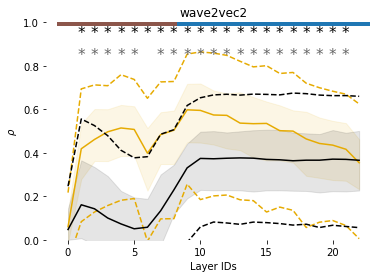

In [2]:
model_name = 'wav2vec2'

area = 'all'
save_tikz = False
# trained_identifier = 'layers_redefined'
# untrained_identifiers = ['reset_redefined']
trained_identifier = 'layers_test'
untrained_identifiers = ['layers_test_shuffle']

# trained_identifier = 'bins_corrected_100'
# untrained_identifier = 'reset_weights'
# untrained_identifier = 'reset_weights1'

trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                # pos_sig_ind=pos_sig_ind,
                # keep_yticks=keep_yticks,
                # keep_xticks=keep_xticks,
                # plot_baseline=plot_baseline,
                # display_inter_quartile_range=display_inter_quartile_range,
                display_dotted_lines=True,
                untrained_identifiers=untrained_identifiers,
                trained_identifier=trained_identifier,
                plot_difference=False
                )

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Peak corr (median): 0.5515196531967943, occurs at x_coordinate: 2
Peak corr (max): 1.0082356960296048, occurs at x_coordinate: 0
Peak corr (median): 0.534155988497037, occurs at x_coordinate: 2
Peak corr (max): 0.9912552343606493, occurs at x_coordinate: 0
p-value for 0: 0.0010400880423330674
p-value for 1: 5.928397727652246e-06
p-value for

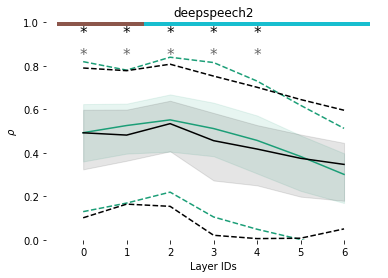

In [2]:
# model_name = 'wav2letter_modified'
# model_name = 'wav2vec2'
# model_name = 'speech2text'
# model_name = 'whisper_tiny'
# model_name = 'whisper_base'
model_name = 'deepspeech2'
area = 'all'
save_tikz = False
trained_identifier = 'trained_all_bins'
untrained_identifiers = [
    'reset_weights', 'reset_weights0', 'reset_weights1', 'reset_weights2'
                         ]

trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                display_dotted_lines=True,
                untrained_identifiers=untrained_identifiers,
                trained_identifier=trained_identifier,
                plot_difference=False
                )

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Peak corr (median): 0.6007523142485269, occurs at x_coordinate: 2
Peak corr (max): 1.031500878619482, occurs at x_coordinate: 2
Peak corr (median): 0.5064393124638497, occurs at x_coordinate: 1
Peak corr (max): 0.9174591393153322, occurs at x_coordinate: 4
p-value for 0: 1.0339568859163088e-06
p-value for 1: 5.3977752172309886e-15
p-value f

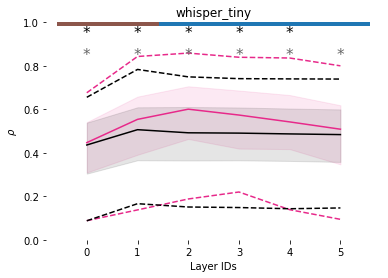

In [3]:
# model_name = 'wav2letter_modified'
# model_name = 'wav2vec2'
# model_name = 'speech2text'
model_name = 'whisper_tiny'
# model_name = 'whisper_base'
# model_name = 'deepspeech2'
area = 'all'
save_tikz = False
trained_identifier = 'trained_all_bins'
untrained_identifiers = [
    'reset_weights', 'reset_weights0', 'reset_weights1', 'reset_weights2'
                         ]

trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                display_dotted_lines=True,
                untrained_identifiers=untrained_identifiers,
                trained_identifier=trained_identifier,
                plot_difference=False
                )

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Peak corr (median): 0.61024476350508, occurs at x_coordinate: 2
Peak corr (max): 1.0379859517184402, occurs at x_coordinate: 2
Peak corr (median): 0.5065627171688016, occurs at x_coordinate: 3
Peak corr (max): 0.9161821761110922, occurs at x_coordinate: 7
p-value for 0: 0.000670966553315556
p-value for 1: 2.2336476318359928e-12
p-value for 

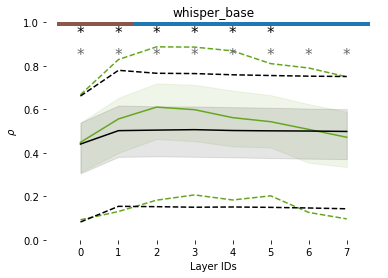

In [4]:
# model_name = 'wav2letter_modified'
# model_name = 'wav2vec2'
# model_name = 'speech2text'
# model_name = 'whisper_tiny'
model_name = 'whisper_base'
# model_name = 'deepspeech2'
area = 'all'
save_tikz = False
trained_identifier = 'trained_all_bins'
untrained_identifiers = [
    'reset_weights', 'reset_weights0', 'reset_weights1', 'reset_weights2'
                         ]

trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                display_dotted_lines=True,
                untrained_identifiers=untrained_identifiers,
                trained_identifier=trained_identifier,
                plot_difference=False
                )

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Peak corr (median): 0.5746180364797386, occurs at x_coordinate: 7
Peak corr (max): 1.063856588735098, occurs at x_coordinate: 5
Peak corr (median): 0.5308707051744326, occurs at x_coordinate: 10
Peak corr (max): 0.9482841047110587, occurs at x_coordinate: 13
p-value for 0: 1.8928661219416292e-07
p-value for 1: 9.701939314201803e-05
p-value 

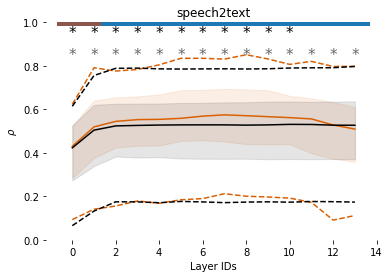

In [5]:
# model_name = 'wav2letter_modified'
# model_name = 'wav2vec2'
model_name = 'speech2text'
# model_name = 'whisper_tiny'
# model_name = 'whisper_base'
# model_name = 'deepspeech2'
area = 'all'
save_tikz = False
trained_identifier = 'trained_all_bins'
untrained_identifiers = [
    'reset_weights', 'reset_weights0', 'reset_weights1', 'reset_weights2'
                         ]

trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                display_dotted_lines=True,
                untrained_identifiers=untrained_identifiers,
                trained_identifier=trained_identifier,
                plot_difference=False
                )

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Peak corr (median): 0.5029990764010088, occurs at x_coordinate: 8
Peak corr (max): 0.9903205063380086, occurs at x_coordinate: 6
Peak corr (median): 0.23800536877298767, occurs at x_coordinate: 0
Peak corr (max): 0.9269896373446775, occurs at x_coordinate: 0
p-value for 0: 0.9956407957680792
p-value for 1: 2.184071639861586e-25
p-value for 

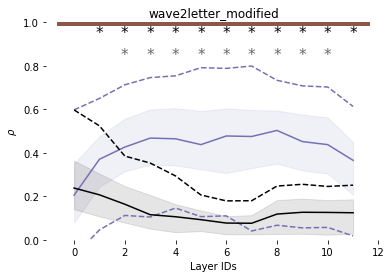

In [6]:
model_name = 'wav2letter_modified'
# model_name = 'wav2vec2'
# model_name = 'speech2text'
# model_name = 'whisper_tiny'
# model_name = 'whisper_base'
# model_name = 'deepspeech2'
area = 'all'
save_tikz = False
trained_identifier = 'trained_all_bins'
untrained_identifiers = [
    'reset_weights', 'reset_weights0', 'reset_weights1', 'reset_weights2'
                         ]

trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                display_dotted_lines=True,
                untrained_identifiers=untrained_identifiers,
                trained_identifier=trained_identifier,
                plot_difference=False
                )

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Peak corr (median): 0.5979916544411191, occurs at x_coordinate: 7
Peak corr (max): 1.0300782923013367, occurs at x_coordinate: 9
Peak corr (median): 0.3580546660734166, occurs at x_coordinate: 18
Peak corr (max): 0.7975619727194821, occurs at x_coordinate: 10
p-value for 0: 0.9543704343478274
p-value for 1: 8.801105641197637e-32
p-value for 2: 5.32076764229855e-35
p-value for 3: 7.080200503777395e-36
p-value for 4: 4.349419014753556e-37
p-value for 5: 5.5810371

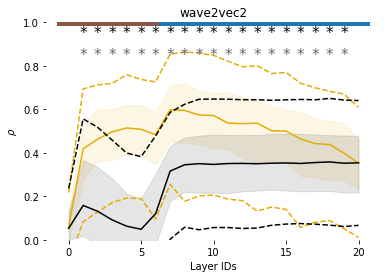

In [7]:
# model_name = 'wav2letter_modified'
model_name = 'wav2vec2'
# model_name = 'speech2text'
# model_name = 'whisper_tiny'
# model_name = 'whisper_base'
# model_name = 'deepspeech2'
area = 'all'
save_tikz = False
trained_identifier = 'trained_all_bins'
untrained_identifiers = [
    'reset_weights', 'reset_weights0', 'reset_weights1'#, 'reset_weights2'
                         ]

trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                display_dotted_lines=True,
                untrained_identifiers=untrained_identifiers,
                trained_identifier=trained_identifier,
                plot_difference=False
                )

In [3]:
a = np.random.randn(2,3)
b = np.random.randn(2,3)

lss = [a,b]

In [8]:
out = np.stack(lss, axis=0)

In [9]:
out.shape

(2, 2, 3)

In [10]:
out = np.mean(out, axis=0)

In [11]:
out.shape

(2, 3)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: bits_per_spike_NLB
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Extracting column: bits_per_spike_NLB
Peak corr (median): 8.620389640925836e-05, occurs at x_coordinate: 2
Peak corr (max): 0.0007093636158881, occurs at x_coordinate: 2
Peak corr (median): 5.198703091677561e-05, occurs at x_coordinate: 2
Peak corr (max): 0.0006426458550109, occurs at x_coordinate: 0
model_name 'baseline' not recognizable!!!


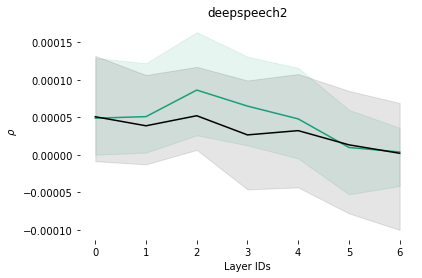

In [3]:
model_name = 'deepspeech2'
# model_name = 'speech2text'
area = 'all'
save_tikz = False
# trained_identifier = 'bins_corrected_100'
# untrained_identifier = 'reset_weights'

trained_identifier = 'glm'
untrained_identifier = 'glm_reset'
column=None
# column = 'uncertainty_per_spike'
column = 'bits_per_spike_NLB'
trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                # pos_sig_ind=pos_sig_ind,
                # keep_yticks=keep_yticks,
                # keep_xticks=keep_xticks,
                # plot_baseline=plot_baseline,
                # display_inter_quartile_range=display_inter_quartile_range,
                untrained_identifier=untrained_identifier,
                trained_identifier=trained_identifier,
                plot_difference=False,
                column=column,
                indicate_significance=False,
                indicate_architecture=False
                )

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: uncertainty_per_spike
Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Extracting column: uncertainty_per_spike
Peak corr (median): 0.00342131017628065, occurs at x_coordinate: 6
Peak corr (max): 0.0074984458031229, occurs at x_coordinate: 5
Peak corr (median): 0.0034716228192223, occurs at x_coordinate: 6
Peak corr (max): 0.0079532301776312, occurs at x_coordinate: 6
model_name 'baseline' not recognizable!!!


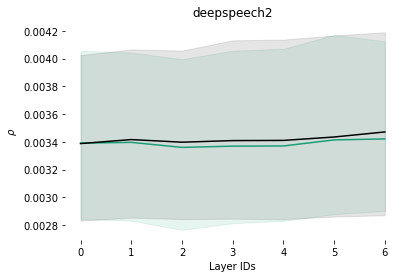

In [5]:
model_name = 'deepspeech2'
# model_name = 'speech2text'
area = 'all'
save_tikz = False
# trained_identifier = 'bins_corrected_100'
# untrained_identifier = 'reset_weights'

trained_identifier = 'glm'
untrained_identifier = 'glm_reset'
column=None
column = 'uncertainty_per_spike'
# column = 'bits_per_spike_NLB'
trained, shuffled, baseline = RegPlotter.plot_all_layers_trained_and_shuffled(
                model_name=model_name,
                # bin_width=bin_width,
                area=area,
                # alpha=alpha,
                save_tikz=save_tikz,
                arch_ind_offset=1,
                arch_ind_lw=8,
                # pos_sig_ind=pos_sig_ind,
                # keep_yticks=keep_yticks,
                # keep_xticks=keep_xticks,
                # plot_baseline=plot_baseline,
                # display_inter_quartile_range=display_inter_quartile_range,
                untrained_identifier=untrained_identifier,
                trained_identifier=trained_identifier,
                plot_difference=False,
                column=column,
                indicate_significance=False,
                indicate_architecture=False
                )

### GLiM (Corr & Entropy)

In [6]:
area='all'
normalized=True
# area='core'
bin_width=20
delay=0
alpha=0.1

keep_xticks = True
keep_yticks = True
save_tikz=False
indicate_significance=False


Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: bits_per_spike_NLB
Peak corr (median): 5.198703091677561e-05, occurs at x_coordinate: 2
Peak corr (max): 0.0006426458550109, occurs at x_coordinate: 0


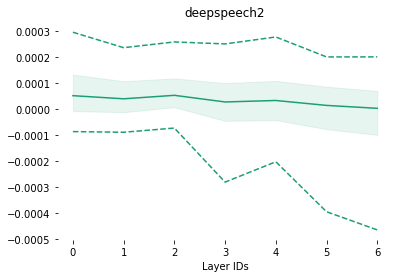

In [10]:
model_name = 'deepspeech2'

identifier='_glm_reset'
column=None
# column = 'poiss_entropy'
# column = 'uncertainty_per_spike'
column = 'bits_per_spike_NLB'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.5289432146016447, occurs at x_coordinate: 2
Peak corr (max): 1.0804875656078752, occurs at x_coordinate: 2


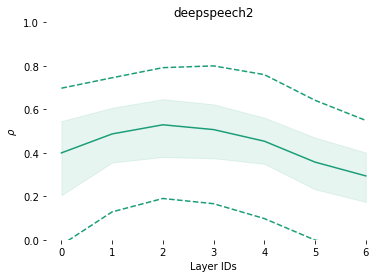

In [3]:
model_name = 'deepspeech2'

identifier='_glm_NLB'
column=None
# column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 1.0257591158820607, occurs at x_coordinate: 6
Peak corr (max): 2.649025227072834, occurs at x_coordinate: 6


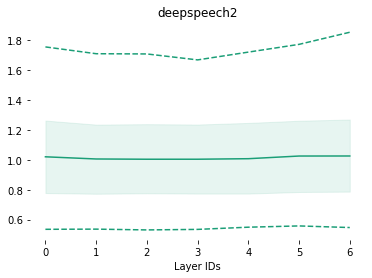

In [4]:
model_name = 'deepspeech2'

identifier='_glm_NLB'
column=None
column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: uncertainty_per_spike
Peak corr (median): 0.00342434096505725, occurs at x_coordinate: 6
Peak corr (max): 0.006905512666877, occurs at x_coordinate: 5


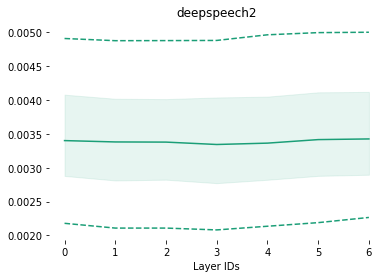

In [5]:
model_name = 'deepspeech2'

identifier='_glm_NLB'
column=None
column = 'uncertainty_per_spike'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: bits_per_spike_NLB
Peak corr (median): 7.981766018557067e-05, occurs at x_coordinate: 3
Peak corr (max): 0.000660737084919, occurs at x_coordinate: 3


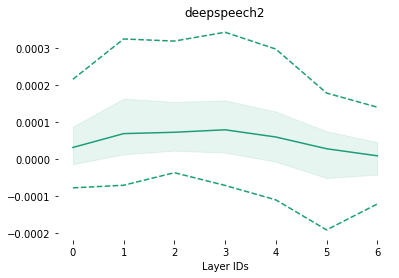

In [6]:
model_name = 'deepspeech2'

identifier='_glm_NLB'
column=None
column = 'bits_per_spike_NLB'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.5313622222236402, occurs at x_coordinate: 2
Peak corr (max): 1.080500529220403, occurs at x_coordinate: 2


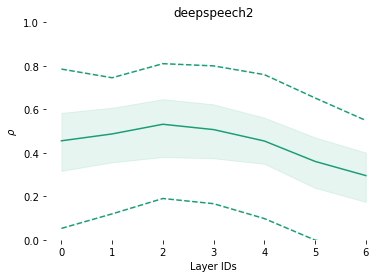

In [3]:
model_name = 'deepspeech2'

identifier='_glm_0'
column=None
# column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 1.0257588206052146, occurs at x_coordinate: 6
Peak corr (max): 2.649025117771364, occurs at x_coordinate: 6


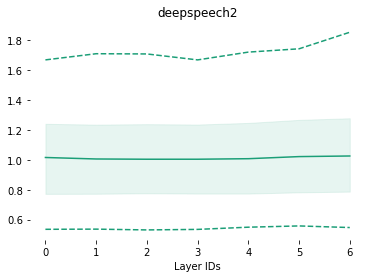

In [4]:
model_name = 'deepspeech2'

identifier='_glm_0'
column=None
column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

#### deepspeech2 (layer-0 not done yet)...

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.5469099344052651, occurs at x_coordinate: 2
Peak corr (max): 1.0907000091891197, occurs at x_coordinate: 2


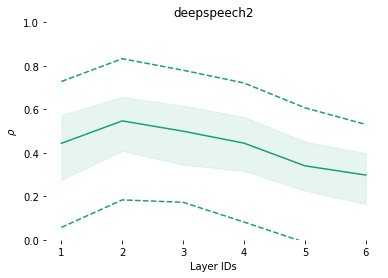

In [7]:
model_name = 'deepspeech2'

identifier='_glm_corrected_1'
column=None
# column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 0.8349967968318552, occurs at x_coordinate: 5
Peak corr (max): 1.0484297517027938, occurs at x_coordinate: 4


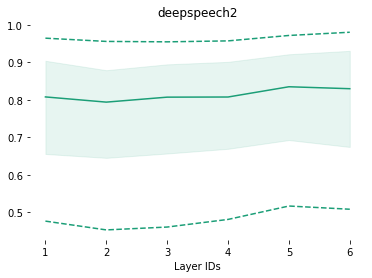

In [8]:
model_name = 'deepspeech2'

identifier='_glm_corrected_1'
column=None
column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

#### speech2text

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.5371752123527015, occurs at x_coordinate: 10
Peak corr (max): 1.0572929475553738, occurs at x_coordinate: 13


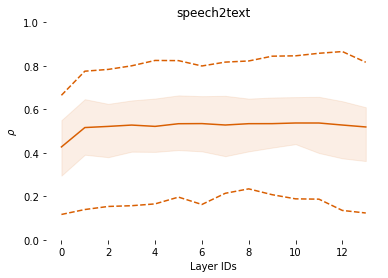

In [4]:
model_name = 'speech2text'

identifier='_glm_corrected_0'
# column = 'poiss_entropy'
column=None
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 0.8106264921606807, occurs at x_coordinate: 0
Peak corr (max): 1.0888834546392296, occurs at x_coordinate: 12


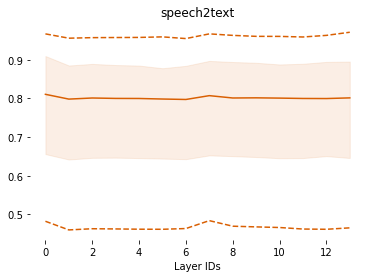

In [5]:
model_name = 'speech2text'

identifier='_glm_corrected_0'
column=None
column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

#### whisper_base

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.6010638301560802, occurs at x_coordinate: 2
Peak corr (max): 1.0673496152962876, occurs at x_coordinate: 7


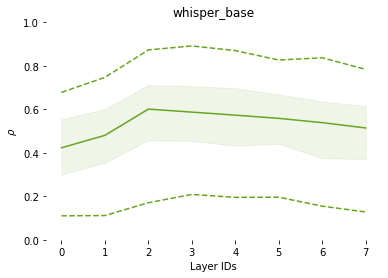

In [15]:
model_name = 'whisper_base'

identifier='_glm_corrected_0'
# column = 'poiss_entropy'
column=None
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 0.8183246742940646, occurs at x_coordinate: 0
Peak corr (max): 1.04887785556857, occurs at x_coordinate: 4


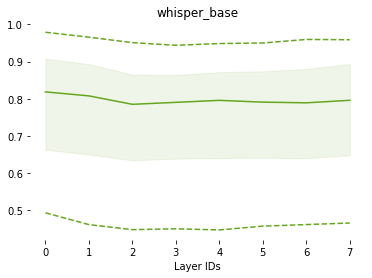

In [16]:
model_name = 'whisper_base'

identifier='_glm_corrected_0'
# identifier='_glm_corrected_2'
column=None
column = 'poiss_entropy'
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

### plotting regression entropy...

In [2]:
area='all'
normalized=True
# area='core'
bin_width=20
delay=0
alpha=0.1

keep_xticks = True
keep_yticks = True
save_tikz=False
indicate_significance=False


In [24]:
model_name = 'wav2letter_modified'
area='all'
# area='core'
bin_width=20
delay=0
alpha=0.1
save_tikz=False
normalized=True
identifier='_bins_corrected_poiss'
column = 'poiss_entropy'
indicate_significance=False
display_inter_quartile_range=True
display_dotted_lines = False
keep_xticks = True
keep_yticks = True

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 4.510662294804627, occurs at x_coordinate: 0
Peak corr (max): 50702.24119719704, occurs at x_coordinate: 0


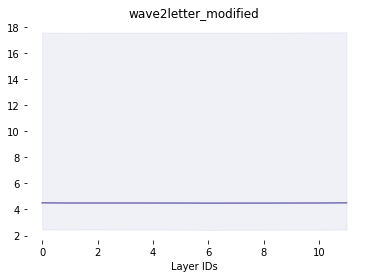

In [25]:
out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines

)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 4.51087443397134, occurs at x_coordinate: 4
Peak corr (max): 50701.55125325073, occurs at x_coordinate: 6


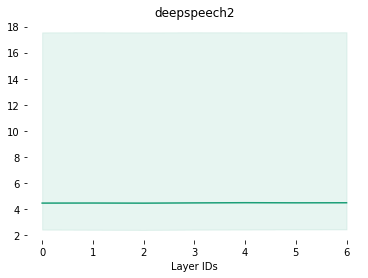

In [30]:
model_name = 'deepspeech2'
display_inter_quartile_range = True
out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines

)


Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 4.940834920258766, occurs at x_coordinate: 0
Peak corr (max): 50705.280267603805, occurs at x_coordinate: 0


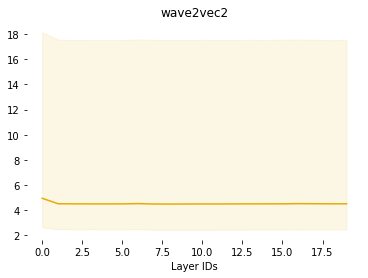

In [27]:
model_name = 'wav2vec2'
out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines

)


Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 4.494569311474289, occurs at x_coordinate: 0
Peak corr (max): 50701.00062350867, occurs at x_coordinate: 0


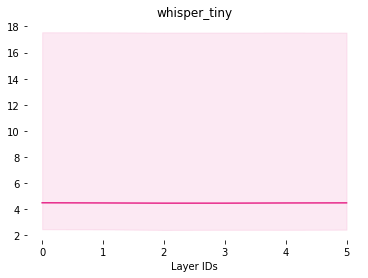

In [28]:
model_name = 'whisper_tiny'
out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines

)


#### deepspeech2, (Layer-0 excluded)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.4933213020064632, occurs at x_coordinate: 2
Peak corr (max): 0.9218184888507802, occurs at x_coordinate: 2


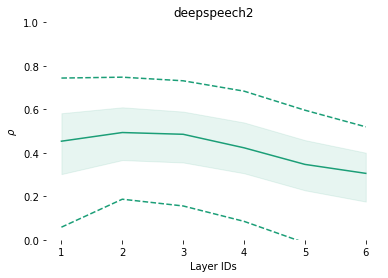

In [95]:
model_name = 'deepspeech2'

identifier='_glm_1'
# column = 'poiss_entropy'
column=None
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 5.2011479773475635, occurs at x_coordinate: 5
Peak corr (max): 50704.12223178203, occurs at x_coordinate: 6


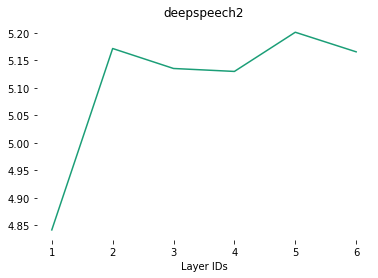

In [98]:
model_name = 'deepspeech2'

identifier='_glm_1'
column = 'poiss_entropy'
# column=None
display_inter_quartile_range=False
display_dotted_lines = False

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)


Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 4.51087443397134, occurs at x_coordinate: 4
Peak corr (max): 50701.55125325073, occurs at x_coordinate: 6


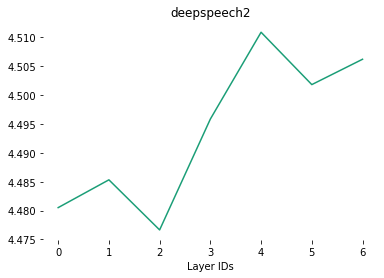

In [99]:
model_name = 'deepspeech2'

column = 'poiss_entropy'
identifier='_bins_corrected_poiss'
# column=None
display_inter_quartile_range=False
display_dotted_lines = False

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

#### speech2text, (Layer-13 excluded)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.5471350490680826, occurs at x_coordinate: 9
Peak corr (max): 0.9680900923034672, occurs at x_coordinate: 5


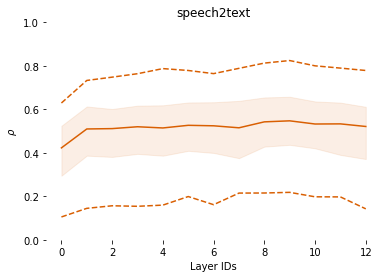

In [100]:
model_name = 'speech2text'

identifier='_glm_0'
# column = 'poiss_entropy'
column=None # None --> normalized_corr
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 5.167072064770347, occurs at x_coordinate: 0
Peak corr (max): 50703.90710008975, occurs at x_coordinate: 0


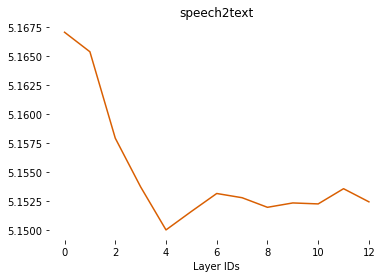

In [101]:
model_name = 'speech2text'

identifier='_glm_0'
column = 'poiss_entropy'
# column=None
display_inter_quartile_range=False
display_dotted_lines = False

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)


Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 4.499054722131488, occurs at x_coordinate: 13
Peak corr (max): 50700.97177278142, occurs at x_coordinate: 0


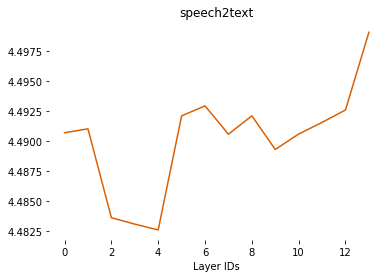

In [102]:
model_name = 'speech2text'

column = 'poiss_entropy'
identifier='_bins_corrected_poiss'
# column=None
display_inter_quartile_range=False
display_dotted_lines = False

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

#### whisper_base

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Peak corr (median): 0.5863497804322266, occurs at x_coordinate: 3
Peak corr (max): 0.9977498495655616, occurs at x_coordinate: 4


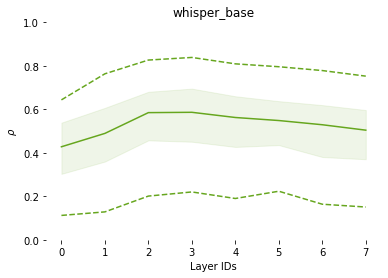

In [87]:
model_name = 'whisper_base'

identifier='_glm_0'
# column = 'poiss_entropy'
column=None
display_inter_quartile_range=True
display_dotted_lines = True

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 5.1695074587485585, occurs at x_coordinate: 0
Peak corr (max): 50703.94612869569, occurs at x_coordinate: 0


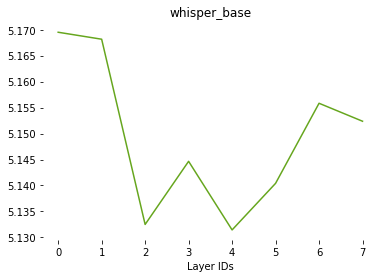

In [86]:
model_name = 'whisper_base'

identifier='_glm_0'
column = 'poiss_entropy'
# column=None
display_inter_quartile_range=False
display_dotted_lines = False

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)


Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Reading exisiting normalizer thresholds...
Extracting column: poiss_entropy
Peak corr (median): 4.495671214692072, occurs at x_coordinate: 6
Peak corr (max): 50701.001542919614, occurs at x_coordinate: 0


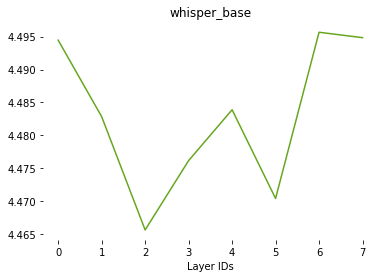

In [91]:
model_name = 'whisper_base'

column = 'poiss_entropy'
identifier='_bins_corrected_poiss'
# column=None
display_inter_quartile_range=False
display_dotted_lines = False

out = RegPlotter.plot_all_network_layers_at_bin_width(
    model_name=model_name,
    area=area,
    bin_width=bin_width,
    save_tikz=save_tikz,
    column = column,
    keep_xticks=keep_xticks,
    keep_yticks=keep_yticks,
    identifier=identifier,
    indicate_significance=indicate_significance,
    display_inter_quartile_range=display_inter_quartile_range,
    display_dotted_lines=display_dotted_lines
)

### Lmbdas for Poisson Regression...

In [4]:
from auditory_cortex.io_utils.io import read_lmbdas

def visualize_lmbda_losses(model_name, layer_ID, session, ch, num_lmbdas=12, ax=None):
    """Visualizes the losses for the range of regularization parameters,
    and the chosen parameter."""
    if ax is None:
        fig, axes = plt.subplots()
        title = "Loss vs L2 regularization parameter ($\lambda$) \n" + \
            f"{model_name}, L-{layer_ID}, sess-{session}"
    else:
        axes = ax
        title = f"ch-{ch}"

    # range of lmbdas explored, known apriori...
    lmbdas = np.logspace(start=-num_lmbdas//2, stop=num_lmbdas, num=int(1.5*num_lmbdas)+1)
    lmbda_dict = read_lmbdas(model_name, layer_ID, session)
    lmbda_loss = lmbda_dict['lmbda_loss'].squeeze()
    optimal_lmbdas = lmbda_dict['optimal_lmbdas'].squeeze()

    chosen_lmbda = optimal_lmbdas[ch]
    arg_lmbda = np.where(lmbdas==chosen_lmbda)[0]
    chosen_lmbda_loss = lmbda_loss[arg_lmbda,ch]

    axes.plot(np.log10(lmbdas), lmbda_loss[:,ch])
    axes.scatter(np.log10(chosen_lmbda), chosen_lmbda_loss, color='red')
    axes.set_xlabel("$log_{10}(\lambda)$")
    axes.set_ylabel("Neg Log Likelihood")
    axes.set_title(title)
    # if ax is None:
    #     axes.


Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl


Text(0, 0.5, 'Neg Log Likelihood')

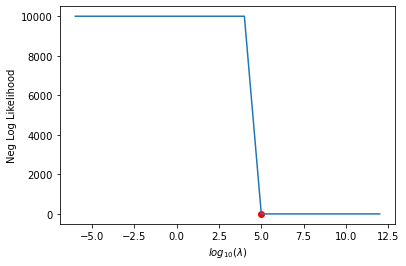

In [6]:
model_name = 'whisper_base'
layer_ID = 0
session = 200206
num_lmbdas = 12
ch = 32

# range of lmbdas explored, known apriori...
lmbdas = np.logspace(start=-num_lmbdas//2, stop=num_lmbdas, num=int(1.5*num_lmbdas)+1)
lmbda_dict = read_lmbdas(model_name, layer_ID, session)
lmbda_loss = lmbda_dict['lmbda_loss'].squeeze()
optimal_lmbdas = lmbda_dict['optimal_lmbdas'].squeeze()

chosen_lmbda = optimal_lmbdas[ch]
arg_lmbda = np.where(lmbdas==chosen_lmbda)[0]
chosen_lmbda_loss = lmbda_loss[arg_lmbda,ch]

plt.plot(np.log10(lmbdas), lmbda_loss[:,ch])
plt.scatter(np.log10(chosen_lmbda), chosen_lmbda_loss, color='red')
plt.xlabel("$log_{10}(\lambda)$")
plt.ylabel("Neg Log Likelihood")
# plt.set_title(title)

In [18]:
lmbda_loss[np.where(lmbda_loss>2)] = 2.5

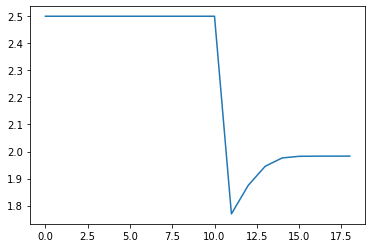

In [21]:
plt.plot(lmbda_loss[:,32])

In [11]:
lmbda_loss.shape

(19, 64)

Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/whisper_base_l0_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas

Text(0.5, 0.98, 'whisper_base, L-0, sess-200206')

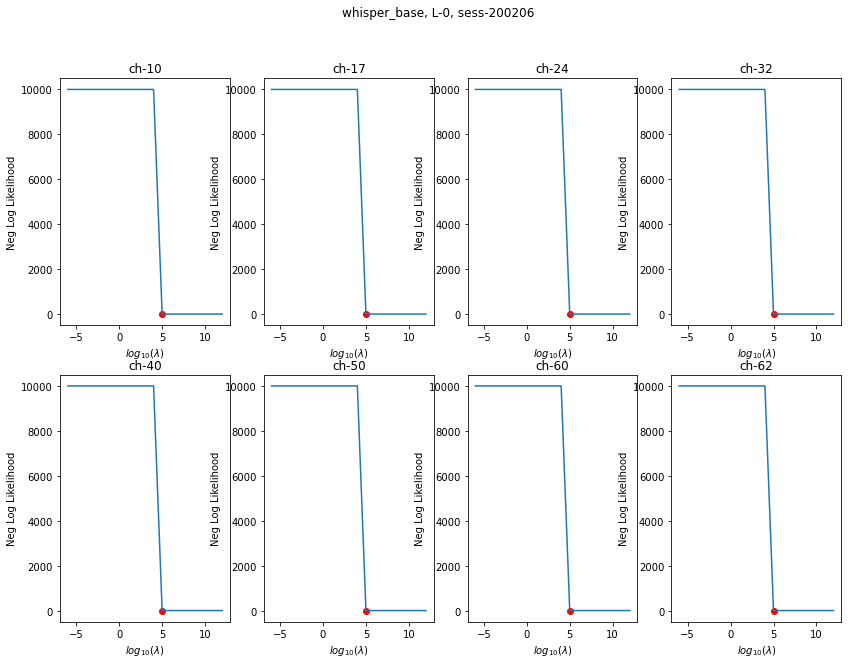

In [76]:
model_name = 'whisper_base'
layer_ID = 0
session = 200206
num_lmbdas = 12
ch = 32

ncols = 4
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14,10))
channels = [10, 17, 24, 32, 40, 50, 60, 62]
for i, ch in enumerate(channels):
    ax = axes[i//ncols, i%ncols]
    visualize_lmbda_losses(model_name, layer_ID, session, ch,
            num_lmbdas=num_lmbdas, ax=ax)
plt.suptitle(f"{model_name}, L-{layer_ID}, sess-{session}")

Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/wav2letter_modified_l6_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/wav2letter_modified_l6_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/wav2letter_modified_l6_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/wav2letter_modified_l6_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/wav2letter_modified_l6_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/wav2letter_modified_l6_sess_200206_optimal_lmbdas_and_losses_20ms.pkl


Text(0.5, 0.98, 'wav2letter_modified, L-6, sess-200206')

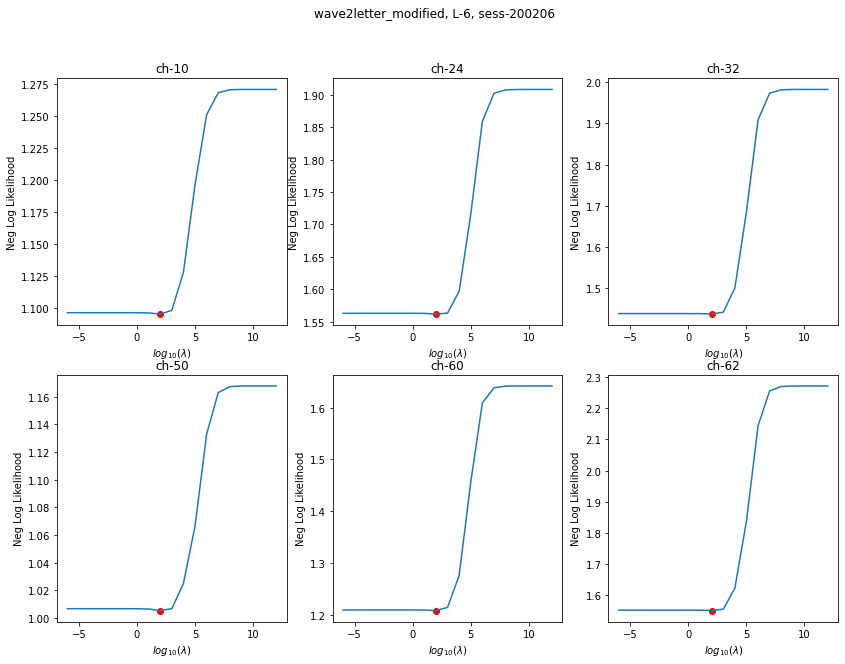

In [75]:
model_name = 'wav2letter_modified'
layer_ID = 6
session = 200206
num_lmbdas = 12
ch = 32

ncols = 3
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14,10))
channels = [10, 24, 32, 50, 60, 62]
for i, ch in enumerate(channels):
    ax = axes[i//ncols, i%ncols]
    visualize_lmbda_losses(model_name, layer_ID, session, ch,
            num_lmbdas=num_lmbdas, ax=ax)
plt.suptitle(f"{model_name}, L-{layer_ID}, sess-{session}")

Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/deepspeech2_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/deepspeech2_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/deepspeech2_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/deepspeech2_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/deepspeech2_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/deepspeech2_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl


Text(0.5, 0.98, 'deepspeech2, L-2, sess-200206')

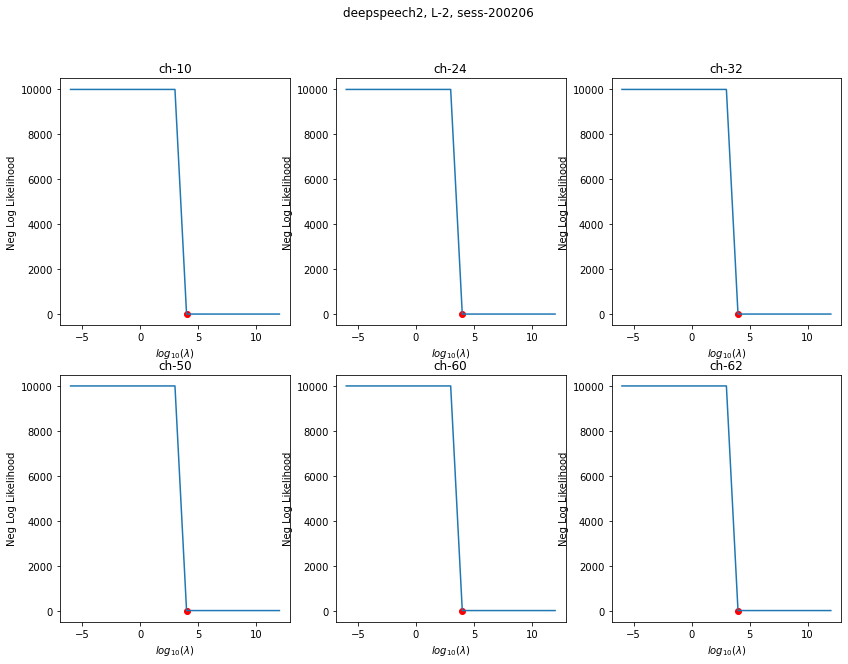

In [74]:
model_name = 'deepspeech2'
layer_ID = 2
session = 200206
num_lmbdas = 12
ch = 32

ncols = 3
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14,10))
channels = [10, 24, 32, 50, 60, 62]
for i, ch in enumerate(channels):
    ax = axes[i//ncols, i%ncols]
    visualize_lmbda_losses(model_name, layer_ID, session, ch,
            num_lmbdas=num_lmbdas, ax=ax)
plt.suptitle(f"{model_name}, L-{layer_ID}, sess-{session}")

Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/speech2text_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/speech2text_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/speech2text_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/speech2text_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/speech2text_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl
Reading from file: /depot/jgmakin/data/auditory_cortex/results/lmbdas/speech2text_l2_sess_200206_optimal_lmbdas_and_losses_20ms.pkl


Text(0.5, 0.98, 'speech2text, L-2, sess-200206')

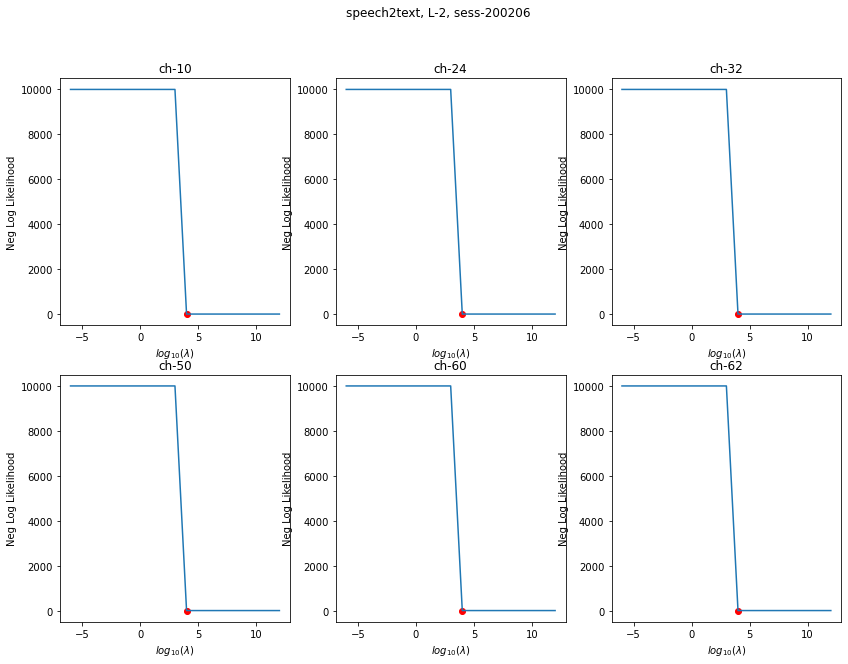

In [73]:
model_name = 'speech2text'
layer_ID = 2
session = 200206
num_lmbdas = 12
ch = 32

ncols = 3
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14,10))
channels = [10, 24, 32, 50, 60, 62]
for i, ch in enumerate(channels):
    ax = axes[i//ncols, i%ncols]
    visualize_lmbda_losses(model_name, layer_ID, session, ch,
            num_lmbdas=num_lmbdas, ax=ax)
plt.suptitle(f"{model_name}, L-{layer_ID}, sess-{session}")